In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from batchflow import plot
from batchflow.models.metrics import ClassificationMetrics

from loader import ImagesDataset

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)

In [4]:
DATA_PATH = '../images'
dataset = ImagesDataset(path=DATA_PATH, encode_labels=True)
n_classes = dataset.label_encoder.classes_.size

100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  4.19it/s]


/notebooks/taine/notebooks/../src/loader.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs['preloaded'] = {'images': np.array(images), 'labels': np.array(labels)}


Classes are imbalanced, loss weighting might be a good idea.

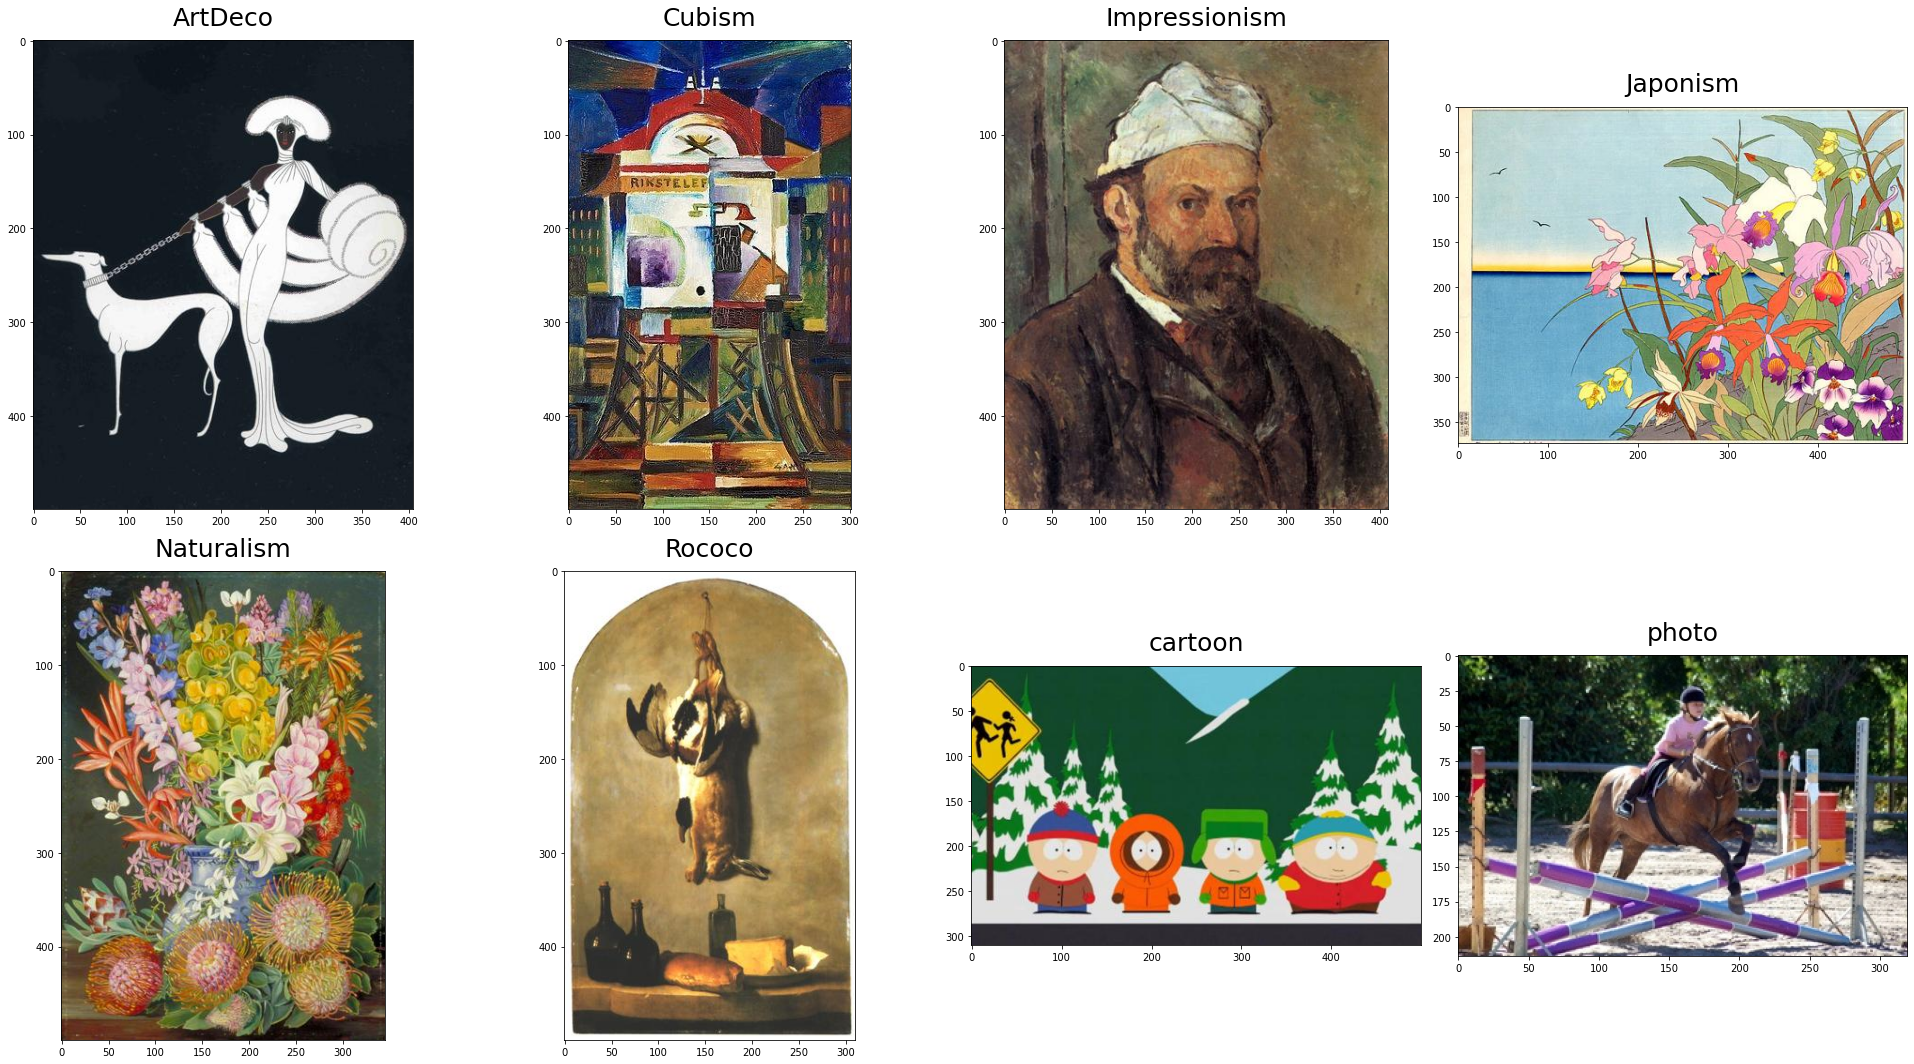

In [5]:
indices = [rng.choice(np.nonzero(dataset.labels == label)[0]) for label in range(n_classes)]
images = list(dataset.images[indices])
labels = dataset.label_encoder.inverse_transform(dataset.labels[indices]).tolist()
plot(data=images, title=labels, combine='separate')

In [6]:
dataset.split(shuffle=SEED)

labels = dataset.labels[dataset.test.indices]
uniques, counts = np.unique(labels, return_counts=True)
shares = counts / counts.sum()
guesses = rng.choice(range(n_classes), p=shares, size=dataset.test.size)

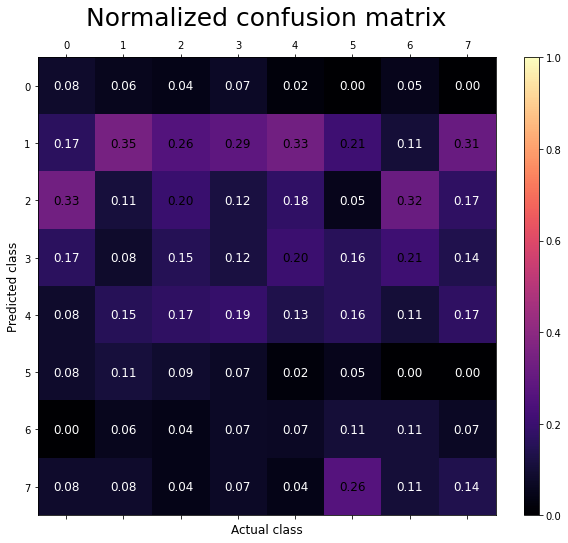

In [7]:
metrics = ClassificationMetrics(labels, guesses, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [13]:
metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=['shares', *metrics_names])

,names,counts,shares,precision,recall
0,ArtDeco,12,4%,8%,8%
1,Cubism,72,25%,30%,34%
2,Impressionism,46,16%,19%,19%
3,Japonism,42,14%,12%,11%
4,Naturalism,45,15%,13%,13%
5,Rococo,19,6%,5%,5%
6,cartoon,19,6%,11%,10%
7,photo,29,10%,16%,13%


In [9]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,18%,14%


In [11]:
METRICS_PATH = '../metrics/guess.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
np.save(METRICS_PATH, all_metrics)